In [1]:
import h5py
import numpy as np
import gzip
import matplotlib.pyplot as plt
import os
from lsst.sims.photUtils import BandpassDict, Sed, Bandpass
from lsst.sims.photUtils import cache_LSST_seds, getImsimFluxNorm
from lsst.utils import getPackageDir

_galaxy_sed_dir = os.path.join(getPackageDir('sims_sed_library'))

sed_look_dir = "/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup/"
lookupfile = os.listdir(sed_look_dir)

In [2]:
cd gcr-catalogs-master/

/global/cscratch1/sd/zg64/gcr-catalogs-master


In [3]:
file_s_e = list()
for i,f in enumerate(lookupfile):
    try:
        look_file = sed_look_dir + f
        hf = h5py.File(look_file, 'r')
        n = hf.get('galaxy_id')
        n = np.array(n)
        file_s_e.append([n[0],n[-1]])
    except:
        print(i,look_file)

57 /global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup/sed_fit_10572.h5


In [4]:
def find_h5_file (gal_id = 1250443219):

    for i,f in enumerate(file_s_e):
        if gal_id > f[0] and gal_id < f[1]:
            if i > 57:
                which_h5file = i + 1
            else:
                which_h5file = i
            print('SED LookupFile: ', lookupfile[which_h5file])
    return(which_h5file)


def find_target_sed(gal_id = 1250443219):
    
    h5f_id = find_h5_file(gal_id=gal_id)
    look_file = sed_look_dir + lookupfile[h5f_id]
    hf = h5py.File(look_file, 'r')
    galaxy_id = hf['galaxy_id'][:]
    bulge_sed = hf['bulge_sed'][:]
    disk_sed = hf['disk_sed'][:]
    sed_names = hf['sed_names'][:]

    idx = np.where(galaxy_id == gal_id)[0][0]

    target_bulge = sed_names[bulge_sed[idx]]
    target_bulge_sed = target_bulge.decode("utf-8") 
    
    target_disk = sed_names[disk_sed[idx]]
    target_disk_sed = target_disk.decode("utf-8") 
    print('SED template (bulge): ',target_bulge_sed)
    print('SED template (disk): ',target_disk_sed)
    
    fig,ax = plt.subplots(1,1,figsize = (8,6))
    ax2 = ax.twinx()
    
    bulge_spec = Sed()
    bulge_spec.readSED_flambda(os.path.join(_galaxy_sed_dir, target_bulge_sed))
    m = bulge_spec.wavelen < 2000
    ax.plot(bulge_spec.wavelen[m],bulge_spec.flambda[m],color = 'c', label = 'bulge')
    ax.legend(loc = 'upper right',fontsize = 14)
    ax.set_ylabel('bulge',fontsize = 16)
    disk_spec = Sed()
    disk_spec.readSED_flambda(os.path.join(_galaxy_sed_dir, target_disk_sed))
    ax2.plot(disk_spec.wavelen[m],disk_spec.flambda[m],color = 'm',label = 'disk') 
    ax2.legend(loc = 'upper left',fontsize = 14)
    ax2.set_ylabel('disk',fontsize = 16)
    ax.set_xlabel('Wavelength [nm]',fontsize = 16)
    return(hf,idx,bulge_spec,disk_spec)


In [120]:
gal_id=1251315986

SED LookupFile:  sed_fit_8786.h5
SED template (bulge):  galaxySED/Inst.32E09.04Z.spec.gz
SED template (disk):  galaxySED/Const.12E10.0005Z.spec.gz


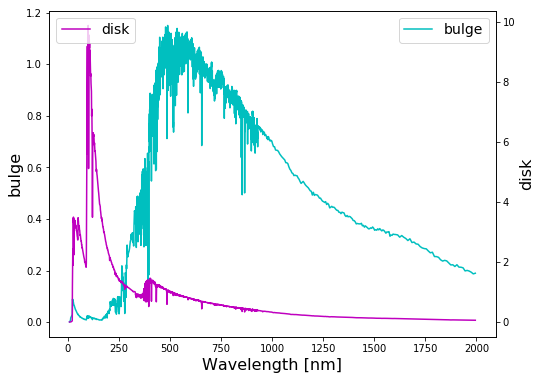

In [130]:
hfile,ID,bulge_s,disk_s = find_target_sed(gal_id=1251315986)

In [131]:
disk_magnorm = hfile['disk_magnorm'][0][ID]
bulge_magnorm = hfile['bulge_magnorm'][0][ID]
print('redshift: ',hfile['redshift'][ID])

fnorm = getImsimFluxNorm(disk_s, disk_magnorm)
disk_s.multiplyFluxNorm(fnorm)
ax, bx = disk_s.setupCCM_ab()
disk_s.addDust(ax, bx, A_v=hfile['disk_av'][ID], R_v=hfile['disk_rv'][ID])

fnorm = getImsimFluxNorm(bulge_s, bulge_magnorm)
bulge_s.multiplyFluxNorm(fnorm)
ax, bx = bulge_s.setupCCM_ab()
bulge_s.addDust(ax, bx, A_v=hfile['bulge_av'][ID], R_v=hfile['bulge_av'][ID])

redshift:  0.7875538386868639


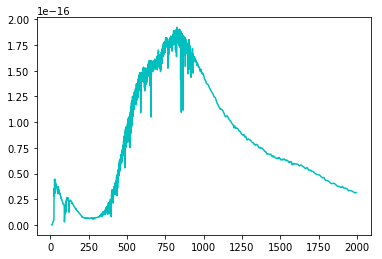

In [149]:
spec_f = Sed(wavelen =  bulge_s.wavelen , flambda = bulge_s.flambda+disk_s.flambda)
m =(spec_f.wavelen < 2000)&(spec_f.wavelen > 0)
f,ax = plt.subplots(1,1)
ax.plot(spec_f.wavelen[m],spec_f.flambda[m],color = 'c', label = 'bulge')

In [124]:
lsst_bp_dict,dummy_bp_dict = BandpassDict.loadBandpassesFromFiles()

In [150]:
## Manual calculate fluxs and mags
spec_f.flambdaTofnu()
try_band = lsst_bp_dict['g']
wavelen,fnu = spec_f.resampleSED(spec_f.wavelen,spec_f.fnu, wavelen_match=try_band.wavelen)
fluxx = np.sum(fnu*try_band.phi)*0.1
mag_try_band = -2.5*np.log10(fluxx) + 2.5*np.log10(3631)
print(mag_try_band)

21.913247835886466


In [151]:
# check with LSST code
spec_f = Sed(wavelen =  bulge_s.wavelen , flambda = bulge_s.flambda+disk_s.flambda)
spec_f.calcMag(bandpass=lsst_bp_dict['g'])

21.91324783588622

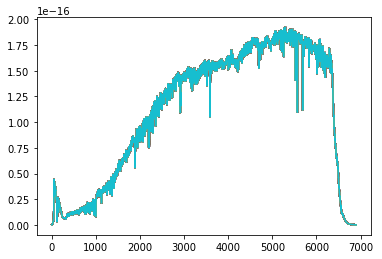

In [148]:
# Run for various redshift and calculate colors
spec_f = Sed(wavelen =  bulge_s.wavelen , flambda = bulge_s.flambda+disk_s.flambda)
redshift = np.arange(0,1.2,0.01)
color = list()
for z in redshift:
    spec_f = Sed(wavelen =  bulge_s.wavelen , flambda = bulge_s.flambda+disk_s.flambda)
    plt.plot(spec_f.flambda)
    spec_f.redshiftSED(z,dimming = True)
    maglist = lsst_bp_dict.magListForSed(spec_f)
    color.append(maglist[:-1]-maglist[1:])

In [152]:
np.save('data/single_gal_cali_u_%i'%gal_id,np.array(color))